In [ ]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import iv, gammaincc

In [ ]:
def generalized_marcum_q(M, a, b):
    return 0.5 * np.exp(-0.5 * (a**2 + b**2)) * np.sqrt(np.pi) * b**(M-1) * gammaincc(M-1, (b**2)/2) + iv(M-1, a * b) * np.exp(-0.5 * a**2)

def pvalue_weight(y1, y2, β1, β2, sigma):
  return generalized_marcum_q(len(y1)/2, np.min([β1, β2]) / sigma, np.linalg.norm(y1 - y2) / sigma)

In [ ]:
# FUNCTIONS DEFINED HERE: GAUSSIAN KERNEL, BETA CALCULATOR, THE S, D and L MATRICES CALCULATORS

def gaussian_kernel(y1, y2, β1, β2):
    return np.exp(-np.linalg.norm(y1 - y2)**2 / (β1 * β2))

def compute_β(V, y, M):
    assert M <= len(V), "M must be at most len(V)"
    norm_list = np.array([np.linalg.norm(vi-y) for vi in V])
    norm_list = norm_list[norm_list > 0]
    norm_list.sort()
    return np.sum(norm_list[:M]) / M

def compute_similarity_matrix(similarity_function="gaussian", **kw_args):
    if similarity_function=="gaussian":
        V, M = kw_args["compute_β"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = gaussian_kernel(V[i], V[j], βi, βj)
                res[i, j] = loc_value
                res[j, i] = loc_value
        res = np.maximum(res, res.T)
        return res
    else: #p-value
        V, M = kw_args["compute_β"]
        sigma = kw_args["RDT_sigma"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = pvalue_weight(V[i], V[j], βi, βj, sigma)
                res[i, j] = loc_value
                res[j, i] = loc_value
        res = np.maximum(res, res.T)
        return res

def compute_D(similarity_matrix):
    return np.diag(np.sum(similarity_matrix, axis=1))

def compute_lagrangian(similarity_function="gaussian", **kw_args):
    S = compute_similarity_matrix(similarity_function=similarity_function, **kw_args)
    D = compute_D(S)
    return D - S

In [ ]:
# THE HISTOGRAM HEURISTIC FUNCTION

# test_bins is the value that you can fit, which is a segmentation of the interval so that you can
# discriminate between a noise and an identity vector

def get_ker_vec_hist_heuristic(eig_vec, test_bins):
  res = []
  N = eig_vec.shape[0]
  for i in range(N):
    count, bins = np.histogram(eig_vec[:, i], bins=test_bins)
    test_value = len(count[count != 0])
    if test_value <= 3:
      res.append(eig_vec[:, i])
  return np.array(res)

In [ ]:
# OBSERVATION FUNCTION DEFINITION
def observe_smooth_circles(ns, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):

        θ = np.linspace(0, 2*np.pi, thres)

        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ])
            res[i, 1] = R[iR] * np.sin(θ[iθ])
    return res

def observe_smooth_circles_noisy(ns, sigma, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):

        θ = np.linspace(0, 2*np.pi, thres)

        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ]) + sigma * np.random.normal(0, sigma)
            res[i, 1] = R[iR] * np.sin(θ[iθ]) + sigma * np.random.normal(0, sigma)
    return res

from sklearn import datasets
from sklearn import preprocessing
def create_data(nsample, sigma):
    X, z = datasets.make_moons(n_samples=nsample, noise=sigma, random_state=0)
    # Generates toy data (moon-shaped data points) and labels
    sc = preprocessing.StandardScaler()  # StandardScaler standardizes features by removing the mean and scaling to unit variance
    sc.fit(X)  # Compute the mean and standard deviation to be used for later scaling
    X_norm = sc.transform(X)  # Standardize features by subtracting the mean and scaling to unit variance
    return X_norm, z

In [ ]:
obs = observe_smooth_circles(200,1,4, 7, 10)

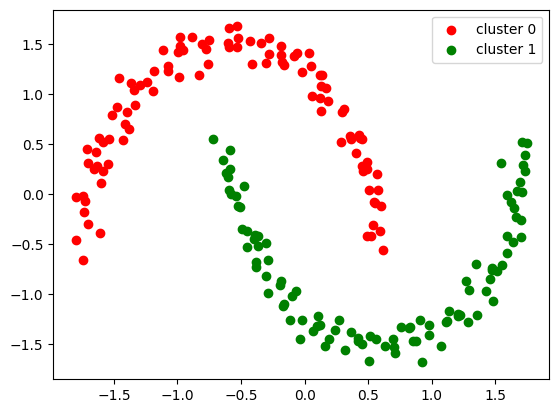

In [ ]:
# DEFINITION OF OBSERVATIONS
# obs = observe_smooth_circles(200,1,4, 7, 10)

sigmaRDT = 0.00
# obs = observe_smooth_circles_noisy(200, sigmaRDT,1,5,11)
obs, classGT = create_data(200, 0.05)
kw = {"compute_β":[obs, 3], "RDT_sigma":sigmaRDT}

# COMPUTATION OF LAGRANGIAN AND EIGEN VECTORS
L = compute_lagrangian(similarity_function = "gaussian", **kw)
eig_val, eig_vec = np.linalg.eig(L)


# ESTIMATION OF THE EIGEN VECTORS FROM THE KERNEL OF L
test_bins = 80
res_eig = get_ker_vec_hist_heuristic(eig_vec, test_bins)

# GET THE SUBSEQUENT CLASSES
K = len(res_eig)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(res_eig.T)
classes = km.predict(res_eig.T)

# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = obs[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}")
plt.legend()

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 50.]),
 array([-1.00017033e-01, -9.86834884e-02, -9.73499441e-02, -9.60163998e-02,
        -9.46828555e-02, -9.33493112e-02, -9.20157669e-02, -9.06822226e-02,


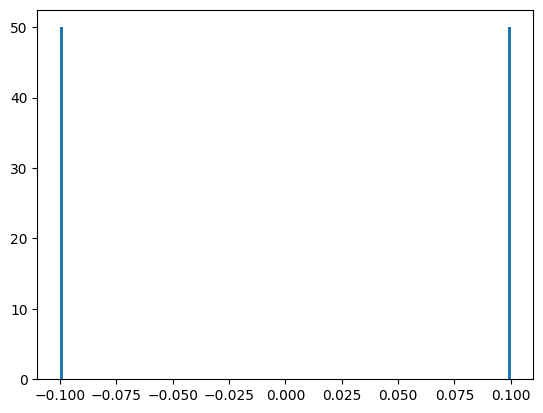

In [ ]:
plt.hist(res_eig[1], bins=150)

In [ ]:
for i in range(nb_classes):
  L_up = np.triu(L[classes==i][:, classes==i], k=1)
  L_up = -L_up.flatten()
  L_up = L_up[L_up > 0]

  L_up_test = np.triu(L[classes==i][:, classes!=i], k=1)
  L_up_test = -L_up_test.flatten()
  L_up_test = L_up_test[L_up_test > 0]
  print(f"weight sum inside class {i}: {np.sum(L_up)}, between class {i} and the other: {np.sum(L_up_test)}")

weight sum inside class 0: 33.56655327336537, between class 0 and the other: 0.0017304239346240772
weight sum inside class 1: 68.43729177646182, between class 1 and the other: 0.0017304239316961187
weight sum inside class 2: 33.56655327336537, between class 2 and the other: 8.740983767849856e-33


In [ ]:
L1 = L[classes==1][:, classes==1][:50, :50]
L2 = L[classes==1][:, classes==1][50:, 50:]

In [ ]:
L[classes==1][:, classes==1][:50, 50:]

(50, 50)

In [ ]:
L_up = np.triu(L1, k=1)
L_up = -L_up.flatten()
L_up = L_up[L_up > 0]

L_up_test = np.triu(L[classes==1][:, classes==1][:50, 50:], k=1)
L_up_test = -L_up_test.flatten()
L_up_test = L_up_test[L_up_test > 0]

print(f"weight sum inside class {1.0}: {np.sum(L_up)}, between class {1.0} and the {1.1}: {np.sum(L_up_test)}")

weight sum inside class 1.0: 33.56655327336537, between class 1.0 and the 1.1: 0.3731146311987438


In [ ]:
import numpy as np
from scipy.special import iv, gammaincc

def generalized_marcum_q(M, a, b):
    return 0.5 * np.exp(-0.5 * (a**2 + b**2)) * np.sqrt(np.pi) * b**(M-1) * gammaincc(M-1, (b**2)/2) + iv(M-1, a * b) * np.exp(-0.5 * a**2)

# Example usage:
M = 2
gamma = 1.5
a = 2
b = 3
result = generalized_marcum_q(M, a, b)
print("Generalized Marcum Q(M={}, gamma={}, a={}, b={}) = {:.6f}".format(M, gamma, a, b, result))


Generalized Marcum Q(M=2, gamma=1.5, a=2, b=3) = 8.301773


In [ ]:
def is_mersenne(n):
  '''
  input: n
  form : 2^n - 1
  '''
  s0 = 4
  sn = s0
  for i in range(1, n-1):
    sn = sn**2 - 2
  M = 2**n - 1
  rem = sn % M
  if rem != 0:
    return False
  div = sn // M
  return div

In [ ]:
is_mersenne(8)

False

In [ ]:
from scipy import spatial

In [ ]:
tree = spatial.KDTree(obs)

In [ ]:
dist, nn_islands = tree.query(obs, k=16)

In [ ]:
dist[0]

array([0.00000000e+00, 2.44929360e-16, 1.28140440e-01, 1.28140440e-01,
       2.55754323e-01, 2.55754323e-01, 3.82317257e-01, 3.82317257e-01,
       5.07309168e-01, 5.07309168e-01, 6.30216436e-01, 6.30216436e-01,
       7.50534010e-01, 7.50534010e-01, 8.67767478e-01, 8.67767478e-01])